# 43Growth-modeling-ARIMA
> The purpose of the notebook is to try out an ARIMA model that applies a growth factor to the final prediction to get iPhone 14 prediction values. The final growth rate applied is 512.13% as that is the calculated mean growth rate from iPhone 13 to iPhone 14 claims.

> There are 4 ARIMA tests conducted to tune the p, d, q, hyperparameters. To balance out the WMAPE values while acknowledging the final prediction values, we would propose ARIMA Test - Version 4 that is using p = 1, d = 0, and q = 4 as the final values to conduct the modeling in this notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pmdarima as pm
import os
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from pmdarima.arima import ADFTest
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score
import warnings

In [2]:
#Constants/globals
os.chdir('/data/p_dsi/teams2023/team9/')
os.getcwd()

In [3]:
#load the data
data = pd.read_csv("Asurion_clean_data_feature_set.csv")
display(data.info())
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11684 entries, 0 to 11683
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   phone model       11684 non-null  object
 1   phone size        11684 non-null  object
 2   phone color       11684 non-null  object
 3   claim             11684 non-null  int64 
 4   weeks_monday      11684 non-null  object
 5   month             11684 non-null  object
 6   year              11684 non-null  int64 
 7   season            11684 non-null  object
 8   quarter           11684 non-null  object
 9   Holidays_Boolean  11684 non-null  bool  
 10  company           11684 non-null  object
 11  model_group       11684 non-null  object
dtypes: bool(1), int64(2), object(9)
memory usage: 1015.6+ KB


None

,phone model,phone size,phone color,claim,weeks_monday,month,year,season,quarter,Holidays_Boolean,company,model_group
0,apple iphone 11,128gb,black,252,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
1,apple iphone 11,128gb,green,45,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
2,apple iphone 11,128gb,purple,92,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
3,apple iphone 11,128gb,red,69,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
4,apple iphone 11,128gb,white,91,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
5,apple iphone 11,128gb,yellow,5,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
6,apple iphone 11,256gb,black,24,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
7,apple iphone 11,256gb,green,3,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
8,apple iphone 11,256gb,purple,7,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
9,apple iphone 11,256gb,red,9,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11


In [4]:
group_model = data.groupby('model_group')
group_model.first()

,phone model,phone size,phone color,claim,weeks_monday,month,year,season,quarter,Holidays_Boolean,company
model_group,,,,,,,,,,,
iphone 11,apple iphone 11,128gb,black,252,2022-01-24,January,2022,winter,Q1,False,apple
iphone 12,apple iphone 12,128gb,black,68,2022-01-24,January,2022,winter,Q1,False,apple
iphone 13,apple iphone 13,128gb,midnight,11,2022-01-24,January,2022,winter,Q1,False,apple
iphone 14,apple iphone 14,128gb,black,7,2022-11-14,November,2022,autumn,Q4,False,apple
iphone se,apple iphone se,128gb,gray,1,2022-01-24,January,2022,winter,Q1,False,apple
iphone x,apple iphone x,256gb,gray,62,2022-01-24,January,2022,winter,Q1,False,apple


In [5]:
# As discussed with professor and client, remove the last row of aggregate data since it looks like 
# they're incomplete data, this is applied to all models 

iphone11 = data[data["model_group"] == "iphone 11"]
result_iphone_11 = iphone11.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_11 = result_iphone_11[:-1]

iphone12 = data[data["model_group"] == "iphone 12"]
result_iphone_12 = iphone12.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_12 = result_iphone_12[:-1]

iphone13 = data[data["model_group"] == "iphone 13"]
result_iphone_13 = iphone13.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_13 = result_iphone_13[:65]

iphone14 = data[data["model_group"] == "iphone 14"]
result_iphone_14 = iphone14.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_14 = result_iphone_14[:-1]

,weeks_monday,claim
0,2023-02-06,4604
1,2023-01-30,3764
2,2023-01-23,4136
3,2023-01-16,4277
4,2023-01-09,3959
...,...,...
80,2021-07-26,1157
81,2021-07-19,1144
82,2021-07-12,1045
83,2021-07-05,1017


Text(0.5, 1.0, 'iPhone 12 Reversed')

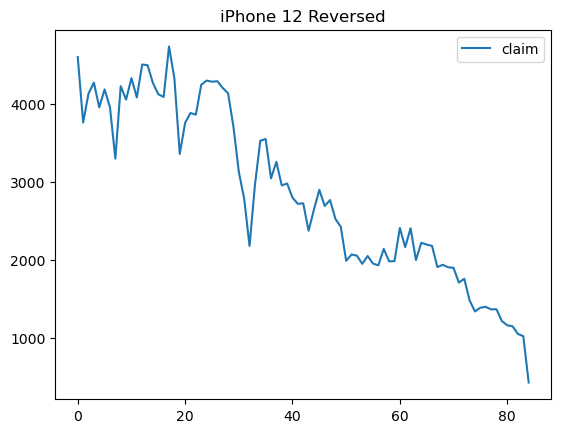

In [6]:
# The goal is to get the index values matched up for iphone 12 and 13 going backwards in time

result_iphone_12_copy = result_iphone_12.copy()

reverse_iphone_12 = result_iphone_12_copy.iloc[::-1].reset_index(drop=True)

display(reverse_iphone_12)

reverse_iphone_12.plot()
plt.title("iPhone 12 Reversed")

#### This is ARIMA Version Test 1

In [7]:
train_12 = reverse_iphone_12['claim']

# Conducting ARIMA in through the format seen below
arima_model_12 = pm.auto_arima(train_12,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5, max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5, max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True, stepwise=True,
          random_state=20, n_fits=50)

arima_model_12.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1068.934, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1058.397, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1050.470, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1062.588, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1051.448, Time=0.25 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1051.059, Time=0.23 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1057.082, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1052.756, Time=0.65 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1052.274, Time=0.14 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1052.422, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1051.426, Time=0.12 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1053.643, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1051.349, Time=0.18 sec

Best model:  ARIMA(0,1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   85
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -522.235
Date:                            Wed, 05 Apr 2023   AIC                           1050.470
Time:                                    23:46:40   BIC                           1057.300
Sample:                                         0   HQIC                          1053.189
                                             - 85                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3765      0.125     -3.022      0.003      -0.621      -0.132
ma.S.L12      -0.6221      0.148     -4.194      0.000      -0.913      -0.331
sigma2      1.081e+05    1.6e+04      6.735      0.000    7.66e+04     1.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.87
Prob(Q):                              1.00   Prob(JB):                         0.14
Heteroskedasticity (H):               0.27   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,predicted_values
85,493.555727
86,407.253254
87,336.486425
88,357.196190
89,325.776788
90,275.733312
91,20.443540
92,40.972591
93,131.452240
94,92.554651


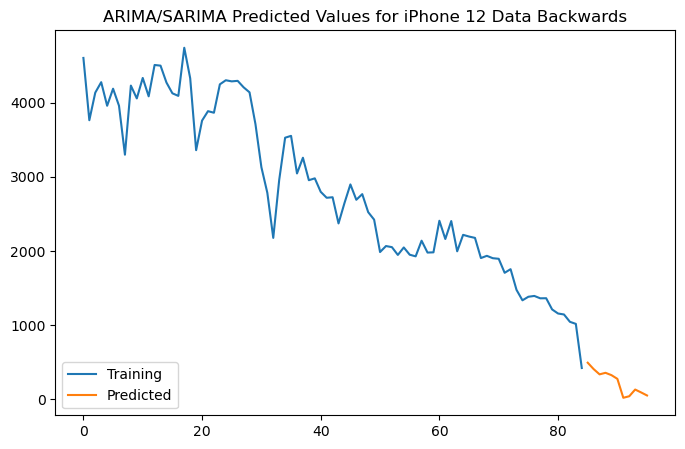

In [8]:
prediction_12 = pd.DataFrame(arima_model_12.predict(n_periods = 11))
prediction_12.columns = ['predicted_values']
display(prediction_12)


plt.figure(figsize=(8,5))
plt.plot(train_12,label="Training")
plt.plot(prediction_12,label="Predicted")
plt.legend(loc = 'lower left')
plt.title("ARIMA/SARIMA Predicted Values for iPhone 12 Data Backwards")
plt.show()

# iPhone 12 release was October 23, 2020, and it is reasonable it takes at least month for first iPhone claimss to start
# Forecasted the data back to around Monday, April 12, 2021 as it became unreasonable to go further as the iPhone 12 claims
# became negative. I was only able to roll it back by 11 weeks before June 28, 2021
# Current lowest value is about 51 on index 95

In [9]:
revised_12 = pd.DataFrame(train_12)
revised_12.columns = ['claim']

prediction_12.columns = ['claim']

frames = [revised_12,  prediction_12]
iphone_12_reversed_final = pd.concat(frames).reset_index(drop = True)

# Use this for the other dataset test
iphone_12_reversed_final_v1 = iphone_12_reversed_final.copy()
iphone_12_reversed_final_v1 = iphone_12_reversed_final_v1.iloc[::-1].reset_index(drop=True).round(decimals = 0)

iphone_12_reversed_final_v1 = iphone_12_reversed_final_v1.rename(columns={'claim': 'iphone_12_claim'})

# To match up with iPhone 13 values, I am adding 12 weeks of data to it, so bringing the data back to January 18, 2021

iphone_12_reversed_final.loc['96'] = [0]
iphone_12_reversed_final.loc['97'] = [0]
iphone_12_reversed_final.loc['98'] = [0]
iphone_12_reversed_final.loc['99'] = [0]
iphone_12_reversed_final.loc['100'] = [0]
iphone_12_reversed_final.loc['101'] = [0]
iphone_12_reversed_final.loc['102'] = [0]
iphone_12_reversed_final.loc['103'] = [0]
iphone_12_reversed_final.loc['104'] = [0]
iphone_12_reversed_final.loc['105'] = [0]
iphone_12_reversed_final.loc['106'] = [0]
iphone_12_reversed_final.loc['107'] = [0]

#iphone_12_reversed_final.tail(15)

iphone_12_reversed_final = iphone_12_reversed_final.iloc[::-1].reset_index(drop=True).round(decimals = 0)

iphone_12_reversed_final = iphone_12_reversed_final.rename(columns={'claim': 'iphone_12_claim'})

# Shortenign the size to match up with iPhone 13 size for test 1
iphone_12_reversed_final = iphone_12_reversed_final[0:65]

iphone_12_reversed_final 

,iphone_12_claim
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
60,2767.0
61,2691.0
62,2898.0
63,2646.0


In [10]:
result_iphone_13.head(20)

,weeks_monday,claim
0,2021-11-15,2
1,2021-11-22,3
2,2021-11-29,6
3,2021-12-06,2
4,2021-12-13,10
5,2021-12-20,6
6,2021-12-27,15
7,2022-01-03,7
8,2022-01-10,13
9,2022-01-17,10


In [11]:
revised_iphone_13 = result_iphone_13.copy()

# Don't cut values of iphone 13, instead just add zeros to iphone 12 start

revised_iphone_13.head(20)
revised_iphone_13 = revised_iphone_13.drop(['weeks_monday'], axis = 1)

revised_iphone_13 = revised_iphone_13.rename(columns={'claim': 'iphone_13_claim'})

frames = [iphone_12_reversed_final,  revised_iphone_13]

result = pd.concat(frames, axis = 1, join = "inner")


#revised_iphone_13
result['growth_rate_percentage'] = (result['iphone_13_claim'] - result['iphone_12_claim']) / result['iphone_12_claim'] * 100

result

display(result.head(15))

# Display mean value growth after removing the infinites that occur from beginning
display(result[12:]['growth_rate_percentage'].mean())
# The percentage means that iPhone 13 grows at avg 62.55% compare to iPhone 12
# After seeing the growth rate and applying these test vales, I don't think it's reasonable so I move on to another combination

,iphone_12_claim,iphone_13_claim,growth_rate_percentage
0,0.0,2,inf
1,0.0,3,inf
2,0.0,6,inf
3,0.0,2,inf
4,0.0,10,inf
5,0.0,6,inf
6,0.0,15,inf
7,0.0,7,inf
8,0.0,13,inf
9,0.0,10,inf


62.55201700656488

## Calculating Growth Rate Between iPhone 13 and iPhone 14 Claims
#### This process gave back a reasonable prediction, so we use this growth rate moving forwards

In [13]:
revised_iphone_14 = result_iphone_14.copy()

revised_iphone_14 = revised_iphone_14.drop(['weeks_monday'], axis = 1)
revised_iphone_14 = revised_iphone_14.rename(columns={'claim': 'iphone_14_claim'})

frames = [revised_iphone_13,  revised_iphone_14]

result_v2 = pd.concat(frames, axis = 1, join = "inner")
result_v2['growth_rate_percentage'] = ((result_v2['iphone_14_claim'] - result_v2['iphone_13_claim']) / result_v2['iphone_13_claim']) * 100
display(result_v2)

## This table shows actual true growth rate percentage values

## This means that iPhone 14 grows at 512.13% over iPhone 13 claims

growth_mean_rate_14 = result_v2['growth_rate_percentage'].mean()

display(growth_mean_rate_14)

,iphone_13_claim,iphone_14_claim,growth_rate_percentage
0,2,9,350.000000
1,3,30,900.000000
2,6,23,283.333333
3,2,43,2050.000000
4,10,32,220.000000
5,6,36,500.000000
6,15,44,193.333333
7,7,45,542.857143
8,13,59,353.846154
9,10,60,500.000000


512.1396107266553

,claim
0,4270
1,3740
2,4090
3,3828
4,3616
...,...
73,59
74,60
75,57
76,54


Text(0.5, 1.0, 'iPhone Combination of 13 and 14')

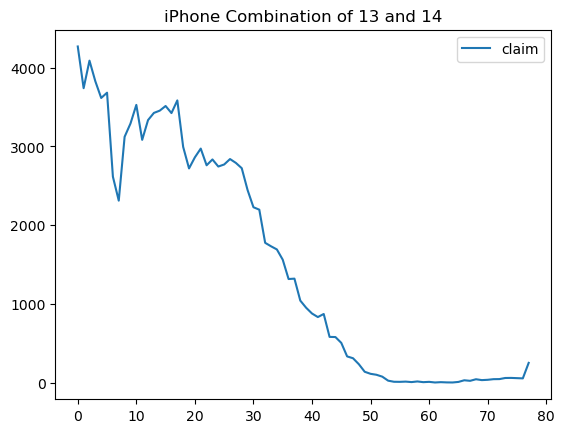

In [14]:
revised_iphone_14_v1 = revised_iphone_14.copy()

reverse_revised_iphone_13 = revised_iphone_13.iloc[::-1].reset_index(drop=True).rename(columns={'iphone_13_claim': 'claim'})

revised_iphone_14_v1 = revised_iphone_14_v1.rename(columns={'iphone_14_claim': 'claim'})

frames = [reverse_revised_iphone_13 , revised_iphone_14_v1 ]
final = pd.concat(frames).reset_index(drop=True)

display(final)
final.plot()
plt.title("iPhone Combination of 13 and 14")

In [15]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [16]:
#split on iPhone 14 values
train_all = final[:74]
test_all = final[-4:]

In [123]:
final = final['claim'].astype('float64')

p_values = [0, 1, 2, 4, 6]
d_values = range(0, 3)
q_values = range(0, 6)
warnings.filterwarnings("ignore")
evaluate_models(final.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=3359742.348
ARIMA(0, 0, 1) MSE=859525.393
ARIMA(0, 0, 2) MSE=349582.415
ARIMA(0, 0, 3) MSE=163927.337
ARIMA(0, 0, 4) MSE=157997.533
ARIMA(0, 0, 5) MSE=65420.088
ARIMA(0, 1, 0) MSE=1628.852
ARIMA(0, 1, 1) MSE=1637.892
ARIMA(0, 1, 2) MSE=1652.842
ARIMA(0, 1, 3) MSE=1623.675
ARIMA(0, 1, 4) MSE=1653.772
ARIMA(0, 1, 5) MSE=6747.841
ARIMA(0, 2, 0) MSE=1743.593
ARIMA(0, 2, 1) MSE=6208.591
ARIMA(0, 2, 2) MSE=7345.685
ARIMA(0, 2, 3) MSE=9448.541
ARIMA(0, 2, 4) MSE=8462.890
ARIMA(0, 2, 5) MSE=9866.580
ARIMA(1, 0, 0) MSE=1925.157
ARIMA(1, 0, 1) MSE=1920.354
ARIMA(1, 0, 2) MSE=1923.211
ARIMA(1, 0, 3) MSE=1890.155
ARIMA(1, 0, 4) MSE=1717.715
ARIMA(1, 0, 5) MSE=13008.098
ARIMA(1, 1, 0) MSE=1636.147
ARIMA(1, 1, 1) MSE=1657.762
ARIMA(1, 1, 2) MSE=2028.923
ARIMA(1, 1, 3) MSE=7574.152
ARIMA(1, 1, 4) MSE=3907.793
ARIMA(1, 1, 5) MSE=6161.067
ARIMA(1, 2, 0) MSE=1747.122
ARIMA(1, 2, 1) MSE=6938.197
ARIMA(1, 2, 2) MSE=6247.730
ARIMA(1, 2, 3) MSE=8336.549
ARIMA(1, 2, 4) MSE=9336.048
ARIMA(1

In [91]:
model_all = ARIMA(train_all, order=(0,1,3))
model_fit_all = model_all.fit()

prediction_all = pd.DataFrame(model_fit_all.forecast(len(test_all)+7))
prediction_all.columns = ['predicted_values']
prediction_all

,predicted_values
74,58.447415
75,57.072572
76,59.106210
77,59.106210
78,59.106210
79,59.106210
80,59.106210
81,59.106210
82,59.106210
83,59.106210


In [18]:
# Checking what is the growth rate between iPhone 13 and iPhone 14 again
growth_mean_rate_14

512.1396107266553

In [92]:
prediction_all_original = prediction_all.copy()

prediction_all_original ['predicted_values'] = prediction_all_original['predicted_values'] * (growth_mean_rate_14/100)
prediction_all_original 

,predicted_values
74,299.332362
75,292.291249
76,302.706315
77,302.706315
78,302.706315
79,302.706315
80,302.706315
81,302.706315
82,302.706315
83,302.706315


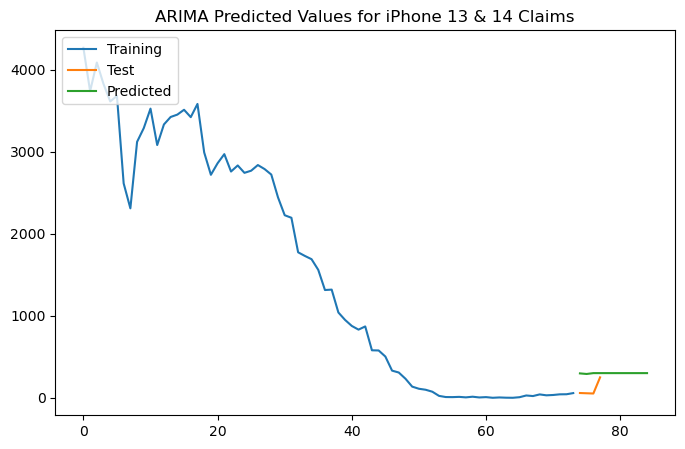

In [93]:
plt.figure(figsize=(8,5))
plt.plot(train_all,label="Training")
plt.plot(test_all,label="Test")
plt.plot(prediction_all_original ,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Predicted Values for iPhone 13 & 14 Claims")
plt.show()

In [94]:
# Checking the test set values of iPhone 14
test_all

,claim
74,60
75,57
76,54
77,251


In [95]:
# Calcualting the WMAPE from this ARIMA test
calculation = prediction_all_original[0:4]

WMAPE_frames = [test_all, calculation]
WMAPE_df = pd.concat(WMAPE_frames, axis = 1)

WMAPE_df['abs_val'] = abs(WMAPE_df['claim'] - WMAPE_df['predicted_values'])

WMAPE_df['weight'] = (WMAPE_df['abs_val'] / WMAPE_df['claim'] *100)*WMAPE_df['claim']

Total_Weight = WMAPE_df['weight'].sum()

Total_Claim = WMAPE_df['claim'].sum()


WMAPE = Total_Weight / Total_Claim

WMAPE

183.65787714676446

#### Conducting hyperparameter tuning by changing p, d, q values
#### We conduct this hyperparameter tuning because the prediction values from ARIMA Test - Version 1 do not seem logicially reasonable

# ARIMA Test - Version 2

In [107]:
model_all_2 = ARIMA(train_all, order=(2,1,3))
model_fit_all_2 = model_all_2.fit()


prediction_all_2 = pd.DataFrame(model_fit_all_2.forecast(len(test_all)+7))
prediction_all_2.columns = ['predicted_values']
prediction_all_2

,predicted_values
74,73.224240
75,97.820925
76,122.191246
77,136.675339
78,138.764050
79,131.731259
80,121.409423
81,113.011764
82,109.255050
83,110.101766


In [108]:
prediction_all_original_2 = prediction_all_2.copy()

prediction_all_original_2['predicted_values'] = prediction_all_original_2['predicted_values'] * (growth_mean_rate_14/100)
prediction_all_original_2


,predicted_values
74,375.010339
75,500.979703
76,625.789773
77,699.968550
78,710.665666
79,674.647959
80,621.785746
81,578.778010
82,559.538388
83,563.874758


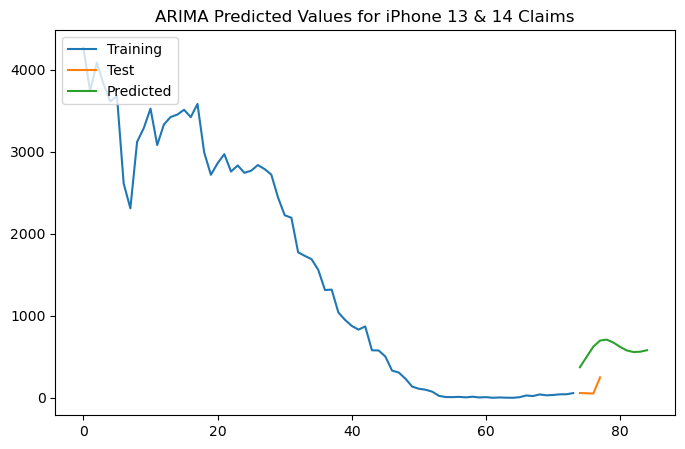

In [109]:
plt.figure(figsize=(8,5))
plt.plot(train_all,label="Training")
plt.plot(test_all,label="Test")
plt.plot(prediction_all_original_2,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Predicted Values for iPhone 13 & 14 Claims")
plt.show()

In [99]:
calculation = prediction_all_original_2[0:4]

WMAPE_frames = [test_all, calculation]
WMAPE_df = pd.concat(WMAPE_frames, axis = 1)

WMAPE_df['abs_val'] = abs(WMAPE_df['claim'] - WMAPE_df['predicted_values'])

WMAPE_df['weight'] = (WMAPE_df['abs_val'] / WMAPE_df['claim'] *100)*WMAPE_df['claim']

Total_Weight = WMAPE_df['weight'].sum()

Total_Claim = WMAPE_df['claim'].sum()


WMAPE = Total_Weight / Total_Claim

WMAPE

421.741318920233

# ARIMA Test - Version 3

In [118]:
model_all_3 = ARIMA(train_all, order=(2,1,5))
model_fit_all_3 = model_all_3.fit()


prediction_all_3 = pd.DataFrame(model_fit_all_3.forecast(len(test_all)+7))
prediction_all_3.columns = ['predicted_values']
prediction_all_3

C:\Users\tiffa.TIFFANY\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,predicted_values
74,103.752301
75,118.909604
76,104.930538
77,136.609267
78,148.439199
79,128.036950
80,96.949888
81,87.899691
82,110.340310
83,140.582959


In [119]:
prediction_all_original_3 = prediction_all_3.copy()

prediction_all_original_3['predicted_values'] = prediction_all_original_3['predicted_values'] * (growth_mean_rate_14/100)
prediction_all_original_3

,predicted_values
74,531.356633
75,608.983182
76,537.390848
77,699.630169
78,760.215936
79,655.727935
80,496.518777
81,450.169136
82,565.096432
83,719.981021


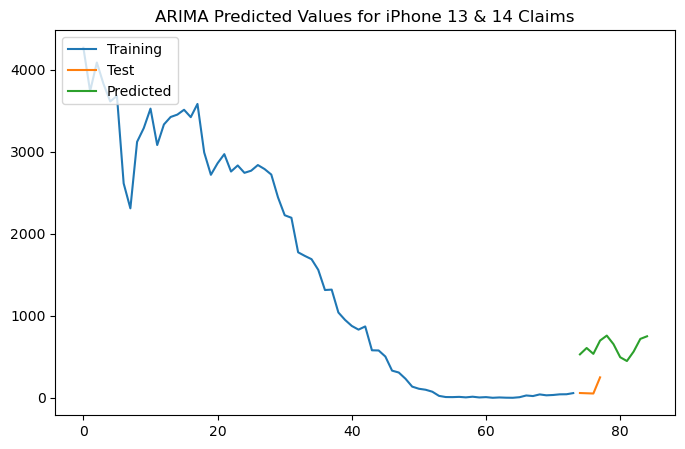

In [120]:
plt.figure(figsize=(8,5))
plt.plot(train_all,label="Training")
plt.plot(test_all,label="Test")
plt.plot(prediction_all_original_3,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Predicted Values for iPhone 13 & 14 Claims")
plt.show()

In [121]:
calculation = prediction_all_original_3[0:4]

WMAPE_frames = [test_all, calculation]
WMAPE_df = pd.concat(WMAPE_frames, axis = 1)

WMAPE_df['abs_val'] = abs(WMAPE_df['claim'] - WMAPE_df['predicted_values'])

WMAPE_df['weight'] = (WMAPE_df['abs_val'] / WMAPE_df['claim'] *100)*WMAPE_df['claim']

Total_Weight = WMAPE_df['weight'].sum()

Total_Claim = WMAPE_df['claim'].sum()


WMAPE = Total_Weight / Total_Claim

WMAPE

463.35564721596444

# ARIMA Test - Version 4

In [125]:
model_all_4 = ARIMA(train_all, order=(1,0,4))
model_fit_all_4 = model_all_4.fit()


prediction_all_4 = pd.DataFrame(model_fit_all_4.forecast(len(test_all)+7))
prediction_all_4.columns = ['predicted_values']
prediction_all_4

C:\Users\tiffa.TIFFANY\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,predicted_values
74,68.394119
75,77.625618
76,88.020825
77,97.973185
78,107.884540
79,117.729772
80,127.509321
81,137.223625
82,146.873120
83,156.458238


In [126]:
prediction_all_original_4 = prediction_all_4.copy()

prediction_all_original_4['predicted_values'] = prediction_all_original_4['predicted_values'] * (growth_mean_rate_14/100)
prediction_all_original_4

,predicted_values
74,350.273373
75,397.551538
76,450.789512
77,501.759489
78,552.519466
79,602.940796
80,653.025739
81,702.776539
82,752.195424
83,801.284611


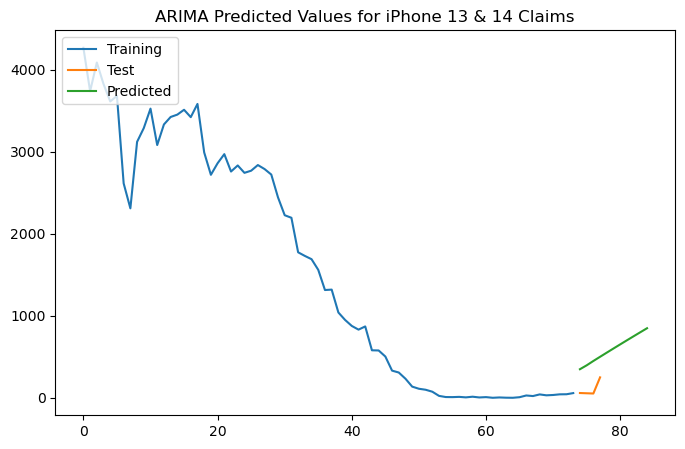

In [127]:
plt.figure(figsize=(8,5))
plt.plot(train_all,label="Training")
plt.plot(test_all,label="Test")
plt.plot(prediction_all_original_4,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Predicted Values for iPhone 13 & 14 Claims")
plt.show()

In [128]:
calculation = prediction_all_original_4[0:4]

WMAPE_frames = [test_all, calculation]
WMAPE_df = pd.concat(WMAPE_frames, axis = 1)

WMAPE_df['abs_val'] = abs(WMAPE_df['claim'] - WMAPE_df['predicted_values'])

WMAPE_df['weight'] = (WMAPE_df['abs_val'] / WMAPE_df['claim'] *100)*WMAPE_df['claim']

Total_Weight = WMAPE_df['weight'].sum()

Total_Claim = WMAPE_df['claim'].sum()


WMAPE = Total_Weight / Total_Claim

WMAPE

302.9322063880853

To balance out the WMAPE values while acknowledging the final prediction values, we would propose ARIMA Test - Version 4 that is using p = 1, d = 0, and q = 4 as the final values to conduct the modeling in this notebook.